<h1> Introduction </h1>

This file is a [jupyter notebook](http://jupyter.org/) describes how to create the figures given in our manuscript: [Shah I, Setzer RW, Jack J, Houck KA, Judson RS, Knudsen TB, Liu J, Martin MT, Reif DM, Richard AM, Thomas RS, Crofton KM, Dix DJ, Kavlock RJ. 2016. Using ToxCast™ data to reconstruct dynamic cell state trajectories and estimate toxicological points of departure. Environ Health Perspect 124:910–919](http://dx.doi.org/10.1289/ehp.1409029). With the appropriate system configuration, database, and software it should be feasible for one skilled in the art to reproduce our results. 

The most recent version of this file and documentation are available [here](https://github.com/i-shah/tippingpoint-ehp-2016) from GitHub.

<h1> Requirements </h1>

All requirements for running this code are open-source:-

<ul>

<li> Operating system: This code has only been tested under [Red Hat Enterprise Linux v6](https://www.redhat.com/en/technologies/linux-platforms/enterprise-linux) and [Ubuntu Server 16.04 LTS](http://www.ubuntu.com). The Ubuntu system can be downloaded freely and installed on any Intel PC. 
 <br>
<li> Python: This code has been tested on [Python 2.7](http://python.org). The easiest way to install Python 2.7 is via [Anaconda](https://www.continuum.io/downloads). Install the python packages given in py_requirements.txt as follows:<br>

<code>
pip install -r py_requirements.txt
</code>
 <br>
 
<li> Jupyter: [Jupyter notebook](http://jupyter.org/) is an interactive computing environment based and is freely available. It can be installed using Anaconda. Please the the documents about Jupyter or find a tutorial on YouTube. <br>

After jupyter is installed read the [quickstart instructions](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/) to create a configuration file. Set the following variables in your jupyter_notebook_config.py:<br>

<pre>
c.NotebookApp.notebook_dir = your_notebook_directory
c.NotebookApp.port = 7777
</pre>
<br>

Start the notebook server from the command line using (I always run this in a [screen](https://www.gnu.org/software/screen/manual/screen.html)): <br>

<pre>
jupyter notebook
</pre>
<br>

Note: If another service is running on port 7777 you will have to change the port number. <br>
 <br>

<li> hts-db: The [hts-db system](https://github.com/i-shah/hts-db) contains the data and functions necessary for replicating the results in this notebook. It is freely available from GitHub. The hts-db system uses Mongo nosql database to store all high-throughput screening (HTS) data from the ToxCast HepG2 high-content imaging (HCI) study including: raw well level data, plate-level normalized data and lowest effect concentration data. The can also be used to manage the raw image data and this capability will be released in future updates. You must download the hts-db system and follow the installation instructions before running this notebook.

<li> Python library: The code depends on a python source file (traj.py) that must be installed locally under your PYTHONPATH so that it can be imported by the interpreter. The python source files required for this notebook should be organized as follows (the source files installed via the hts-db system are included): <br>
<pre>
./__init__.py
./bio/__init__.py
./bio/comp/__init__.py
./bio/comp/traj.py
./bio/comp/hts.py
./bio/data/__init__.py
./bio/data/htsdb.py
./util/__init__.py
./util/misc.py
</pre>
NB: there are underscores around init 

</ul>


<h1> Running the code </h1>
After you have completed the above requirements save this notebook to your_notebook_directory and open [this page](http://localhost:7777) in your browser. Each section of code (called a cell) can be executed by pressing the ">|" button on the menu or by the ctrl-enter key combination to produce the output. All cells must be run sequentially in order to ensure the variables have been initialized.


<h1> Further information </h1>

For further information please contact shah.imran@epa.gov


In [1]:
%load_ext autoreload
%autoreload 2
%load_ext sql 
%pylab inline
%matplotlib inline

import matplotlib.text as text
import scipy.interpolate as interp
import pandas as pd
import statsmodels.api as sm
import numpy.linalg as LA
import pickle,bz2
import numpy as np
import matplotlib.gridspec as gridspec
from textwrap import wrap
import scipy.optimize as optz
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.text as text
import matplotlib.font_manager as fm 
import pylab as pl
from matplotlib.patches import Ellipse, Circle
from collections import *
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from copy import copy
import numpy.linalg as LA
import pickle

from bio.hts.htsdb import *
import bio.comp.hts as hts
import bio.comp.traj as traj




/usr/local/anaconda2/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/usr/local/anaconda2/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


Populating the interactive namespace from numpy and matplotlib


# Data 

* Loading from hts-db

    The data from the original study are stored in a mongodb database using a mongoengine interface. Instructions about building the database are available separately. This step is shown here to explain the source of the data. 


In [ ]:
# Create the following directory to store data - substitute 'your_data_directory' with a real directory
DAT_DIR='your_data_directory'

In [3]:
import numpy.linalg as LA
DATA = []
FT=['p53Act','StressKinase','OxidativeStress','MicrotubuleCSK','MitoMass','MitoMembPot',
    'MitoticArrest','CellCycleArrest','NuclearSize','CellLoss']
LB2 = np.array(['p53','SK','OS','Mt','MM','MMP','MA','CCA','NS','CN'])
LB3 = dict(zip(FT,['p53','SK','OS','Mt','MM','MMP','MA','CCA','NS','CN']))
Exp = HtsExp.objects(cell='HepG2')
#for CRC in HtsConcRespCurveNrm.objects(plate__in=PL,chem__in=HC):
for CRC in HtsConcRespCurveNrm.objects(#chem__in=Exp.chems,
                                       plate__in=HtsPlate.objects(exp__in=HtsExp.objects(cell='HepG2'))):
    D = dict(ch_id=CRC.chem.eid,cid=CRC.chem.cid,chem_name=CRC.chem.name,casrn=CRC.chem.casrn,assay=LB3[CRC.assay.eid],timeh=CRC.timeh)
    for resp in CRC.resp:
        D0 = copy(D)
        D0.update(dict(lc=resp.lconc,lfc=resp.slfc,pct=resp.ppct,zsc=resp.pzsc))
        DATA.append(D0)
DATA_df = pd.DataFrame(DATA)
DATA_df.to_csv(bz2.BZ2File(DAT_DIR+'shah-apr-ehp-2016-data.csv.bz2',mode='w'))

* Loading from the data file.

    Make sure that the location DAT_DIR points to a local directory on your file system

In [2]:
DATA_df = pd.read_csv(bz2.BZ2File(DAT_DIR+'shah-apr-ehp-2016-data.csv.bz2',mode='r'))

## Figure 2. Concentration and time-dependent perturbations produced by chemicals.

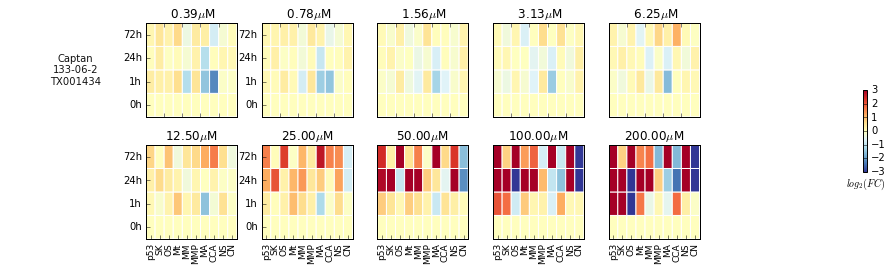

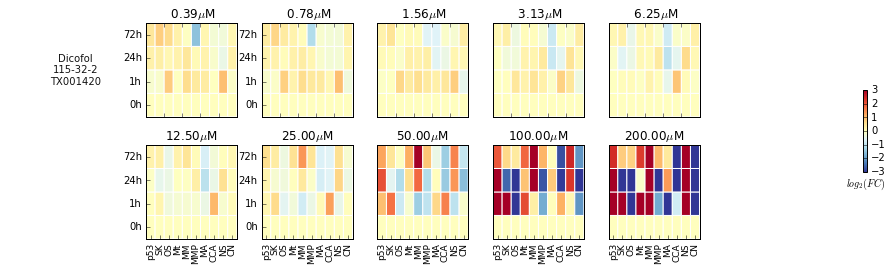

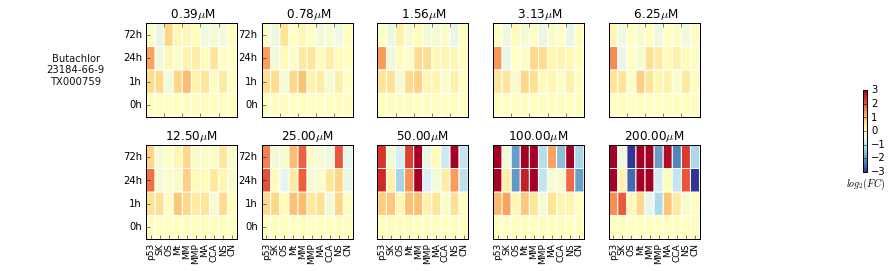

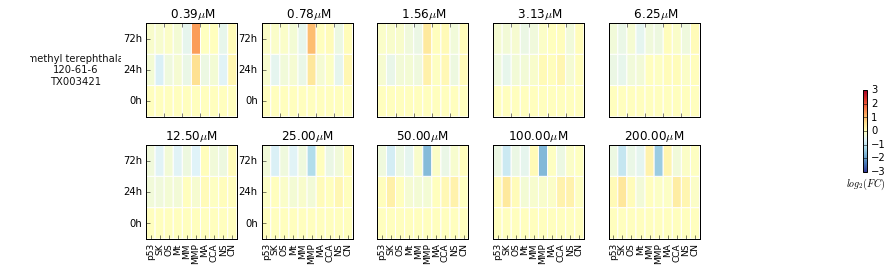

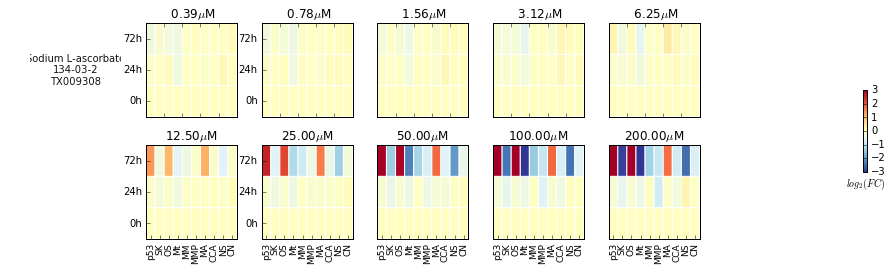

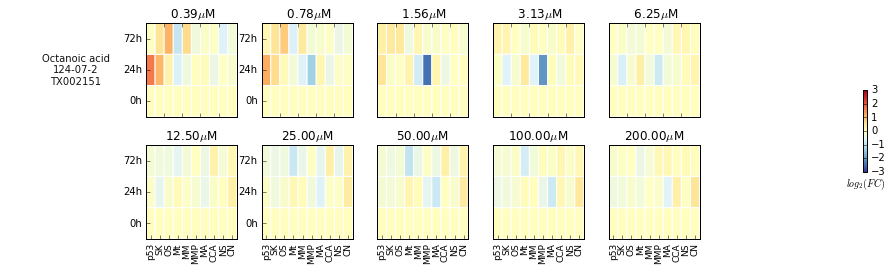

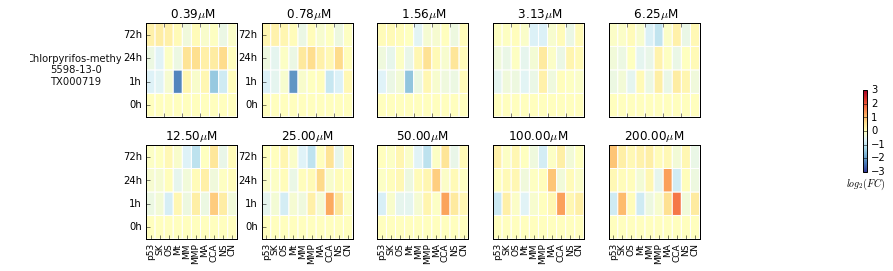

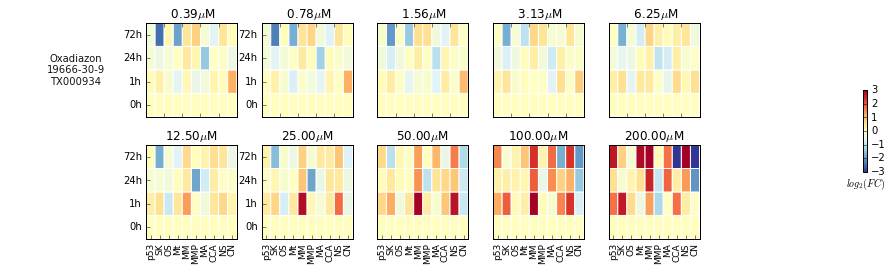

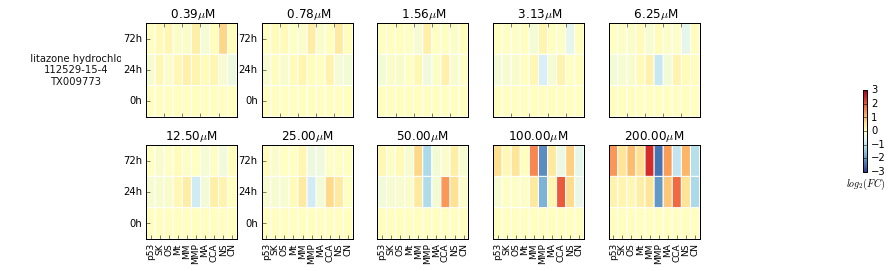

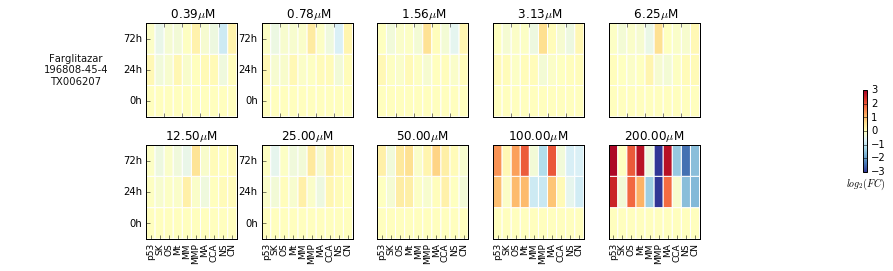

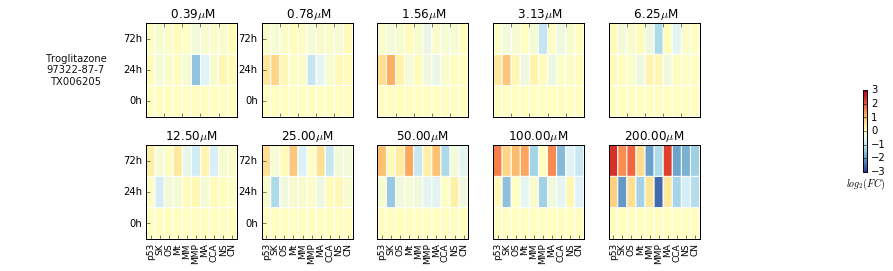

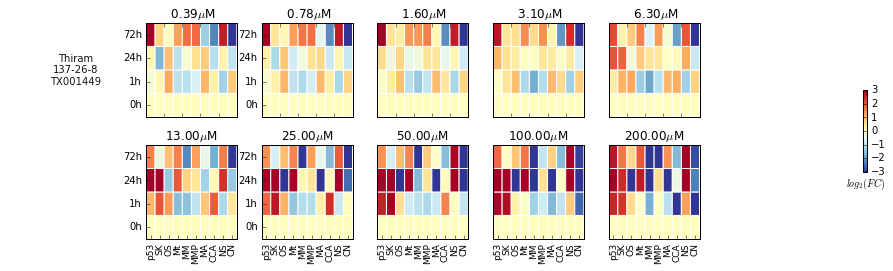

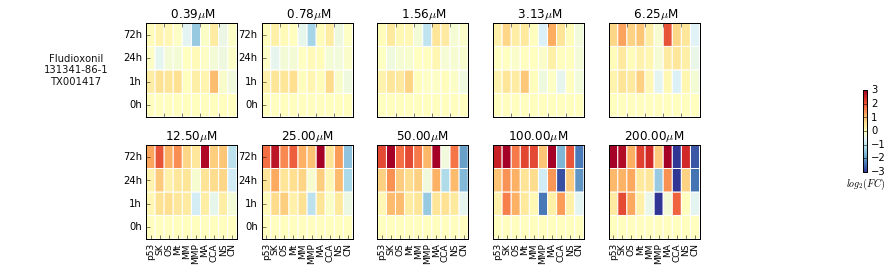

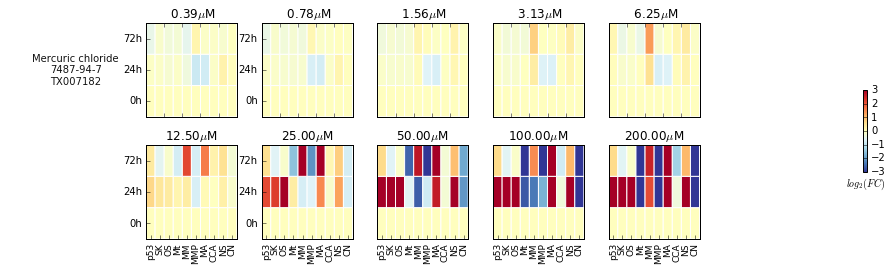

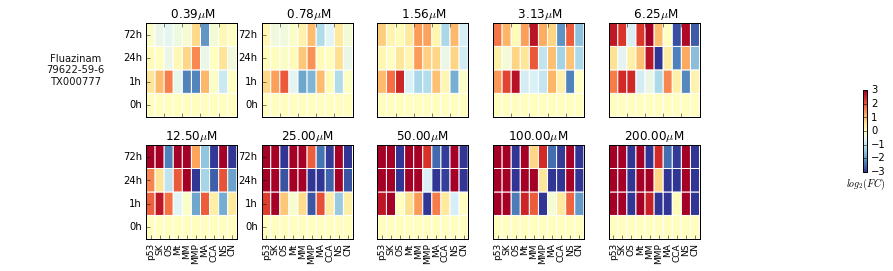

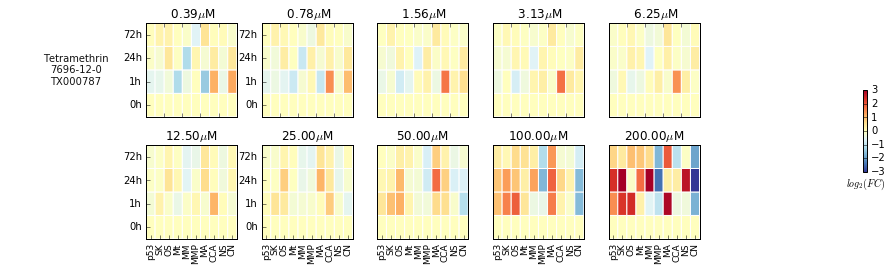

In [104]:

CHEMS=[('TX001434', u'APR-HepG2-PhI'),
 ('TX001420', u'APR-HepG2-PhI'),
 ('TX000759', u'APR-HepG2-PhI'),
 ('TX003421', u'APR-HepG2-PhII'),
 ('TX009308', u'APR-HepG2-PhII'),
 ('TX002151', u'APR-HepG2-PhII'),
 ('TX000719', u'APR-HepG2-PhI'),
 ('TX000934', u'APR-HepG2-PhI'),
 ('TX009773', u'APR-HepG2-PhII'),
 ('TX006207', u'APR-HepG2-PhII'),
 ('TX006205', u'APR-HepG2-PhII'),
 ('TX001449', u'APR-HepG2-PhI'),
 ('TX001417', u'APR-HepG2-PhI'),
 ('TX007182', u'APR-HepG2-PhII'),
 ('TX000777', u'APR-HepG2-PhI'),
 ('TX000787', u'APR-HepG2-PhI')]

for (sid,exp) in CHEMS:
    hts.plotHtsTrajHM(sid,exp_id=exp,add_t0=True,cb=True,use_resp='slfc',
                  draw_chem=False,
                  fs=1.1,xyoff=[2,-4],fgsz=[15,3],loc=None)

## Figure 3. Magnitude of perturbations for trajectories produced by fixed treatment concentrations of different chemicals

In [3]:
# Calculate the 1-norm for the perturbations
V_fc = pd.pivot_table(DATA_df,index=['ch_id','chem_name','cid','timeh','lc'],
                      columns='assay',values='lfc',fill_value=0)
V_fc = V_fc.replace([np.inf,-np.inf,np.nan],0)
V1_fc = (V_fc-V_fc.mean(axis=0))/V_fc.std(axis=0)
V1_fc['norm']=V1_fc.ix[:,:10].apply(lambda x: LA.norm(x),axis=1)


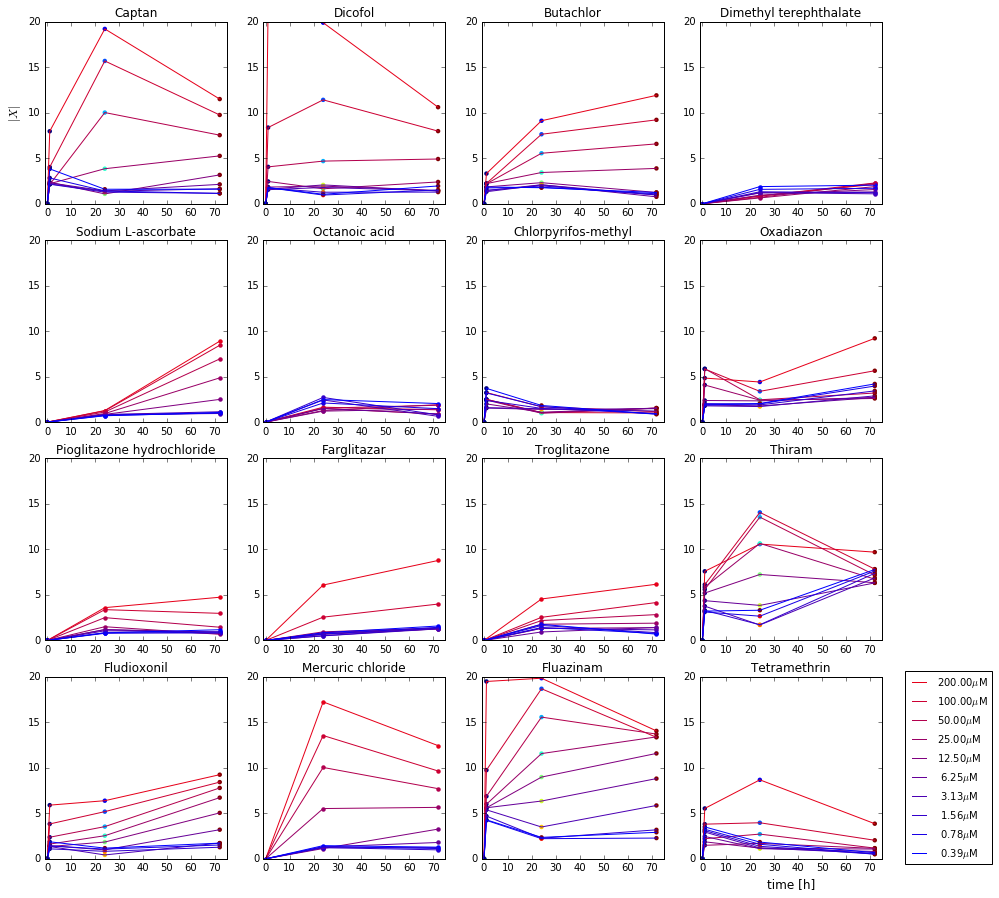

In [121]:
# SHow the scalar perturbation with or without smoothing

SID = [
'TX001434', # captafol
'TX001420', # dicofol
'TX000759',  # butachlor
'TX003421',
'TX009308',
'TX002151',
'TX000719',
'TX000934',
'TX009773', # pioglit
'TX006207',# faarglit
'TX006205',# troglit
'TX001449',# thiram
'TX001417', # fludioxonil
'TX007182',
'TX000777',
'TX000787' #u'Tetramethrin'
]

fig = pl.figure(figsize=(15,15),dpi=400)
j =0
for s in SID:
    j += 1
    F2D = traj.calcCellRespSurface(s,V1_fc,use_t0=True,conc_deg=2,time_deg=2)
    V_fc_s = V1_fc.select(lambda x:x[0]==s)
    V_s = pd.pivot_table(V_fc_s.reset_index(),index=['ch_id','chem_name','lc'],columns='timeh',values='norm')
    ax = pl.subplot(4,4,j)
    T1 = list(V_s.columns)
    T2 = np.linspace(0,72,num=200)
    
    C2 = sorted([i[2] for i in V_s.index],reverse=True)
    k=0
    
    for lc in C2:
        k += 1
        Vi=F2D['fx']['norm'](lc,T2)
        x1=np.array(V_s.columns)
        y1=np.array(V_s.select(lambda x:x[2]==lc))[0,:]
        x1=np.concatenate(([0],x1))
        y1=np.concatenate(([0],y1))
        lc_col=(1-(k*0.1),0,k*0.1,1)
        ax.scatter(x1,y1,marker='o',color=lc_col,linewidths=0)
        
        ax.plot(x1,y1,color=lc_col,label=r'%5.2f$\mu$M'%10**(lc+6))       
        
    ax.set_title(F2D['chem'])
    ax.set_ylim(0,20)
    ax.set_xlim(-1,75)
    if j == 1: ax.set_ylabel(r'$|X|$',fontdict=dict(size=12))
    if j == 16: ax.set_xlabel(r'time [h]',fontdict=dict(size=12))
    
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),prop=dict(size=10))


## Figure 4. Trajectory analysis and critical concentrations of different chemicals at 72 hr.

In [ ]:
# Calculate the Velocity and other derivatives
j=0

DcV_all={}
for s in SID:
    print s
    j += 1
    DcV = pd.DataFrame()
    VD1,VD2,FUNC = traj.calcTrajectoryDerivsSample(s,V1_fc,use_times=[24,72],use_conc=10,k=3)
    DcV[0] = VD2.d2V_dtdc
    
    for ii in range(100):
        VD1i,VD2i,FUNCi = traj.calcTrajectoryDerivsSample(s,V1_fc,use_times=[24,72],use_conc=8,k=3)
        DcV[(ii+1)]=VD2i.d2V_dtdc
    DcV_all[s]=dict(Y_mn=DcV.mean(axis=1),Y_sd=DcV.std(axis=1))

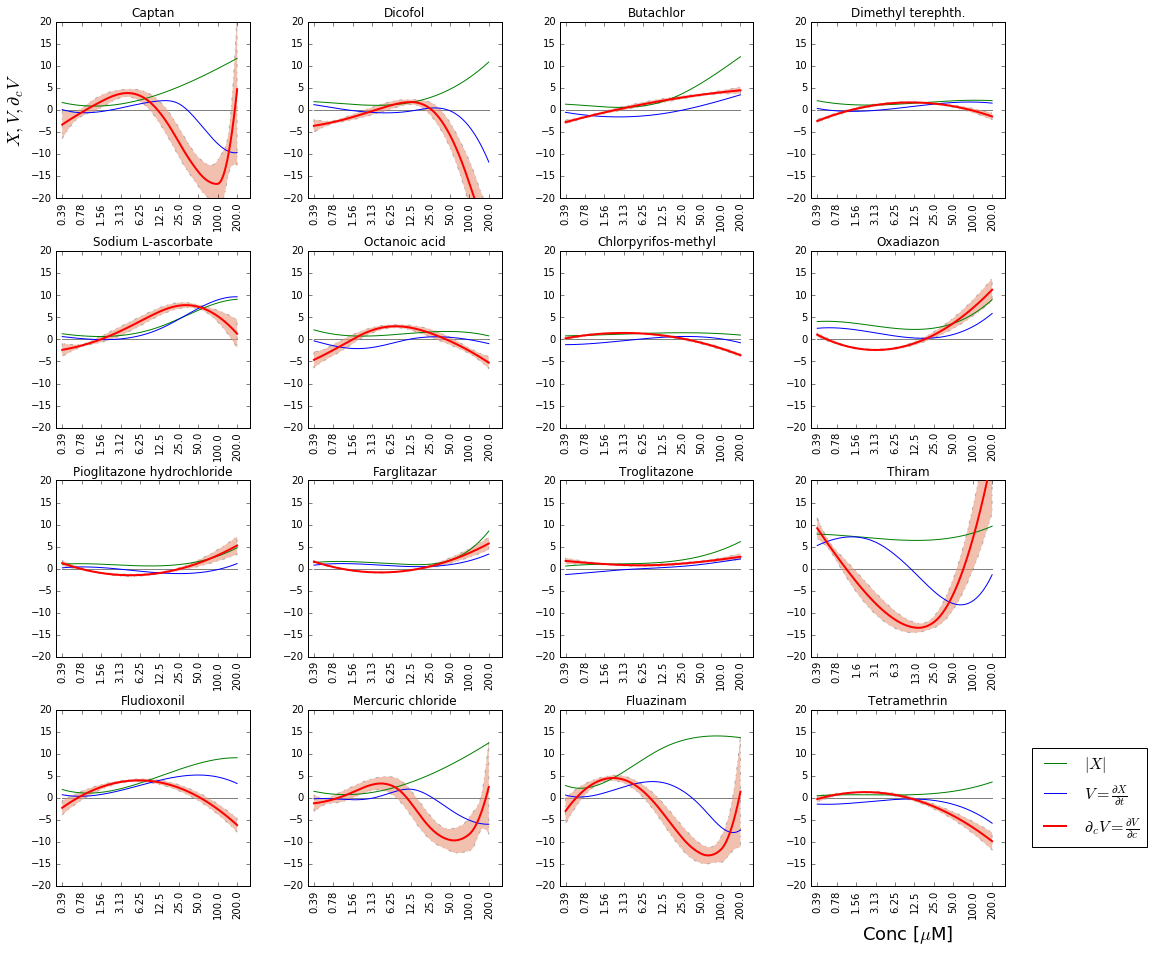

In [133]:
# SHow the scalar perturbation with or without smoothing

SID = [
'TX001434', # captafol
'TX001420', # dicofol
'TX000759',  # butachlor
'TX003421',
'TX009308',
'TX002151',
'TX000719',
'TX000934',
'TX009773', # pioglit
'TX006207',# faarglit
'TX006205',# troglit
'TX001449',# thiram
'TX001417', # fludioxonil
'TX007182',
'TX000777',
'TX000787' #u'Tetramethrin'
]

AX = []
def set_plot_props2(ax1,title):
    ax1.set_title(title)
    ax1.set_xticks(uM_log, minor=False)
    ax1.set_xticklabels(uM,rotation=90)
    for tick in ax1.get_xticklines(): tick.set_visible(True)
    for tick in ax1.get_xticklabels(): tick.set_fontsize(10)
    #ax1.set_ylabel("time [h]")
    #ax1.set_xlabel(r"conc [$\mu$Mol]")

def mkConc(x):
    return r'%5.2f$\muM$' % np.round(10**(cc+6.0),decimals=2)

fig = pl.figure(figsize=(17,15),dpi=400)

j =0

CRIT_res={}
for s in SID:
    j += 1
    VD1,VD2,FUNC = traj.calcTrajectoryDerivs(s,V1_fc,use_times=[24,72],k=3)
    Status,CRIT = traj.calcTrajCritical(FUNC,k=3)
    ax = pl.subplot(4,4,j)
    AX.append(ax)
    if j==16:  ax.set_xlabel(r'Conc [$\mu$M]',fontdict=dict(size=18))
    if j==1: ax.set_ylabel(r'$X,V,\partial_cV$',fontdict=dict(size=18))
    uM_log = VD1.conc.unique()
    uM     = np.round(10**np.array(uM_log + 6,dtype=np.float),decimals=2)
    uM_lab = [r"%5.2f$\muM$" % i for i in  10**np.array(uM_log + 6)]

    ax.plot(VD2.conc,VD2.V,label=r'$|X|$',color='g')
    ax.plot(VD2.conc,VD2.dV_dt,label=r'$V=\frac{\partial X}{\partial t}$',color='b')
    
    cc_col='#333333'
    cc_sign=0
    
    CRIT_res[s]=dict(name=VD1.chem_name[0])
    #print VD1.chem_name[0],ifthen(len(CRIT.c_crit)>0,','.join([str(10**(6+cc)) for cc in CRIT.c_crit.tolist()]),'')
    try:
        icc=0
        for cc in CRIT.c_crit:
            icc+=1
            #if icc != len(CRIT.c_crit): continue
            cc_sign=FUNC['d3V_dtdc2'](cc)[0]
            
            if cc_sign<0:
                cc_col='#333333'
            else:
                cc_col='#ff0000'
            #print VD1.chem_name[0],">Crit conc",cc_str,cc_sign,cc_col
            
            ymin=np.min(VD2.d2V_dtdc)*1
            if cc<VD1.conc.min() or cc>VD1.conc.max(): continue
            ax.add_line(mlines.Line2D((cc,cc),(0,ymin),lw=1,linestyle='--',color='grey',zorder=0))
            cc_str = np.round(10**(cc+6.0),decimals=2)
            ax.add_artist(text.Text(cc,ymin,cc_str,ha='center',va='top',color=cc_col,visible=True,
                                    fontproperties=fm.FontProperties(size=12,weight='normal'),zorder=101))
    
    except:
        pass
    
    # Now plot DcV = d2V_dtdc  
    Y_mn = DcV_all[s]['Y_mn']
    Y_sd = DcV_all[s]['Y_sd']
    ax.plot(VD2.conc,Y_mn,label=r'$\partial_c V=\frac{\partial V}{\partial c}$',color='red',lw=2,zorder=10)#linestyle='--')
    ax.fill_between(VD2.conc,Y_mn-Y_sd,Y_mn+Y_sd,
                    alpha=0.6,edgecolor='#888888',facecolor='#e9967a',
                    linewidth=1,linestyle='dashdot',antialiased=True)

    ax.add_line(mlines.Line2D((VD1.conc.min(),VD1.conc.max()),(0,0), lw=1,color='grey',zorder=0))
    # t=72
    ax.set_ylim(-20,20)
    set_plot_props2(ax,VD1.chem_name[0].replace('phthalate','phth.'))

ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5),prop=dict(size=16))
pl.subplots_adjust(wspace=0.3,hspace=0.3,top=0.9,bottom=0.1)



## Figure 5. Critical concentrations (Ccr) for 340 chemicals at 72 hr.

### Some data used in the figure

In [ ]:
PL = HtsPlate.objects(exp__in=HtsExp.objects(cell='HepG2'))
RES=[]

for ar in HtsAssayResult.objects(plate__in=PL):
    
    RES.append(dict(chem_name=ar.chem.name,hchem_id=ar.chem.eid,chem_casrn=ar.chem.casrn,
                    assay_id=ar.assay.eid,timeh=ar.crc.timeh,llec=ar.llec,eff_fc=ar.lfc_eff,eff_pc=ar.pc_eff))

RES_df=pd.DataFrame(RES)


In [ ]:
EidAb = \
[[u'CellCycleArrest','CCA', 'Cell Cycle Arrest'],
 [u'CellLoss','CN','Cell Number'],
 [u'MicrotubuleCSK','Mt','Microtubules'],
 [u'OxidativeStress','OS', 'Oxidative Stress'],
 [u'p53Act','p53','P53 Activation'],
 [u'StressKinase','SK','JUN Activation'],
 [u'MitoMass','MM', 'Mitochondrial Mass'],
 [u'MitoMembPot','MMP', 'Mitochondrial Memb Pot'],
 [u'MitoticArrest','MA', 'Mitotic Arrest'],
 [u'NuclearSize','NS','Nuclear Size'],
 [u'Apoptosis','Ap', 'Apoptosis'],
 [u'DNADamage','DD','DNA Damage'],
 [u'DNATexture','DT', 'DNA Texture'],
 [u'LysosomalMass','LM', 'Lysosomal Mass'],
 [u'MitoFxnI','MMP', 'Mitochondrial Memb Pot'],
 [u'Steatosis','St', 'Steatosis']]

#for eid,ab,lab in EidAb:
#    HtsAssay.objects(eid=eid).update_one(set__abrv=ab,set__lab=lab)
[[i.eid] for i in HtsAssay.objects]
AssayAbrv = dict([(i[0],i[1]) for i in EidAb])
RES_df['feature']=RES_df.assay_id.apply(lambda i: AssayAbrv[i])

FT2 = np.array(['p53','SK','OS','Mt','MM','MMP','MA','CCA','NS','CN'])

Bioact1_llec=pd.pivot_table(RES_df,columns=['feature'],index=['hchem_id','chem_casrn','timeh'],values='llec',
                           aggfunc=np.min,fill_value=0).ix[:,FT2]
Bioact1_fc=pd.pivot_table(RES_df,columns=['feature'],index=['hchem_id','chem_casrn','timeh'],values='eff_fc',
                           aggfunc=np.min,fill_value=0).ix[:,FT2]



### Calculation of critical concentrations

In [ ]:
SID_ALL = list(set([i[0] for i in V1_fc.index]))
CRIT_res={}
LC = sorted(set([i[-1] for i in V1_fc.select(lambda x: x[0]=='TX001694').index]))
lc_min=min(LC)
lc_max=max(LC)

X1 = []
V1 = []
I1 = []
    
j=0

for hchem_id in SID_ALL:
    HC = HtsChem.objects(eid=hchem_id).first()
    print '>',hchem_id,HC.name
    j += 1
    # t=72h
    try:
        VD1,VD2,FUNC = traj.calcTrajectoryDerivs(hchem_id,V1_fc,use_times=[24,72],k=3)
        Status,CRIT = traj.calcTrajCritical(FUNC,k=3)
        ccx = CRIT.c_crit.tolist()
        CC0 = dict(zip(ccx,FUNC['d3V_dtdc2'](ccx)))
        X1.append(FUNC['V'](LC))
        V1.append(FUNC['dV_dt'](LC))

        Vmax5 = lambda c: FUNC['V'](c)-5
        Vmax2 = lambda c: FUNC['V'](c)-2
        c5 = None
        c2 = None
        try:
            c5 = min(optz.fsolve(Vmax5,[lc_min,lc_max]))
            c2 = min(optz.fsolve(Vmax2,[lc_min,lc_max]))
        except:
            pass
        else:
            c5 = 10**(6+c5)
            c2 = 10**(6+c2)
        Res=dict(hchem_id=hchem_id,name=VD1.chem_name[0],cmin_v5=c5,cmin_v2=c2)
        Res.update(traj.calcCritConc(CC0))
        CCi=[]
        for ii in range(50):
            # t=72
            VD1i,VD2i,FUNCi = traj.calcTrajectoryDerivsSample(hchem_id,V1_fc,use_times=[24,72],use_conc=8,k=3)
            Statusi,CRITi = traj.calcTrajCritical(FUNCi,k=3)
            ccx = CRITi.c_crit.tolist()
            CCi.append(dict(zip(ccx,FUNCi['d3V_dtdc2'](ccx))))
        
        Res.update(traj.calcCritConcSummary(CCi))
        CRIT_res[hchem_id] = Res
    except:
        print ' Failed',hchem_id
    else:
        I1.append(hchem_id)

I1 = np.array(I1)
X72_zs = pd.DataFrame(X1,index=I1)
V72_zs = pd.DataFrame(V1,index=I1)


CRIT_df = pd.DataFrame(CRIT_res.values())
CRIT_df = CRIT_df.set_index(['hchem_id','name'])


In [14]:
X72_zs.head()

,0,1,2,3,4,5,6,7,8,9
TX001601,5.356864,6.243737,8.064854,10.013779,11.419045,12.359472,13.072027,13.799100,14.700555,15.604702
TX001603,0.514159,1.071404,1.400881,1.576342,1.668855,1.753186,1.945821,2.537114,3.860813,6.250667
TX001604,1.714946,1.966198,1.800859,1.419274,1.030655,0.835577,1.039190,1.845677,3.459220,6.084003
TX011588,1.641525,1.690156,1.643653,1.539101,1.415965,1.311297,1.263446,1.310482,1.490479,1.841506
TX001606,0.576857,1.163276,1.381357,1.374164,1.286126,1.261259,1.444053,1.978829,3.009914,4.681629


In [15]:
X72_zs.to_csv(DAT_DIR+'shah-apr-ehp-2016-figure-5b.csv')
V72_zs.to_csv(DAT_DIR+'shah-apr-ehp-2016-figure-5c.csv')

In [ ]:
# Find the concentration that produces 50% cell loss at 72h
CN72 = []
for sid in SID_ALL:
    X72_fc = V_fc.select(lambda x:x[-2]==72 and x[0]==sid).reset_index()
    Lec = hts.calcLECConc(list(X72_fc.lc),list(X72_fc.CN),R_crit=1)
    CN72.append(dict(hchem_id=sid,CN50=Lec))

CN72_df = pd.DataFrame(CN72)

CN72_df['CN50_um'] = 10**(6+CN72_df['CN50'])

# Add scalar mag and velocity
#CRIT_df=CRIT_df.drop(['min_pert','max_pert'],axis=1)

Xmn=X72_zs.min(axis=1).fillna(0.0,inplace=True)
Xmx=X72_zs.max(axis=1).fillna(0.0,inplace=True)

CRIT_df['min_pert']=Xmn.tolist()
CRIT_df['max_pert']=Xmx.tolist()

# Add IC50 for 50% CN
X = CN72_df.reset_index()
CRIT1_df = pd.merge(CRIT_df.reset_index(),X,on='hchem_id')

# Add LEC data 
X = Bioact1_llec.select(lambda x:x[2]==72).reset_index()
CRIT1_df = pd.merge(CRIT1_df,X,on='hchem_id')

CRIT1_df = CRIT1_df.set_index(['hchem_id','chem_casrn','name'])

CRIT1_df.reset_index().to_csv(DAT_DIR+'shah-apr-ehp-2016-figure-5a.csv')


In [16]:
## Load the data to draw the figure

In [5]:
CRIT_df = pd.read_csv(DAT_DIR+'shah-apr-ehp-2016-figure-5.csv')
CRIT_df.set_index(['hchem_id','name','chem_casrn'],inplace=True)
CRIT_df['norecov_mn']=CRIT_df['norecov_mn'].astype(np.float)
CRIT_df['lec_min']=CRIT_df['lec_min'].astype(np.float)
CRIT_df['max_pert']=CRIT_df['max_pert'].astype(np.float)

X72_zs = pd.read_csv(DAT_DIR+'shah-apr-ehp-2016-figure-5b.csv')
V72_zs = pd.read_csv(DAT_DIR+'shah-apr-ehp-2016-figure-5c.csv')

## Draw the figure

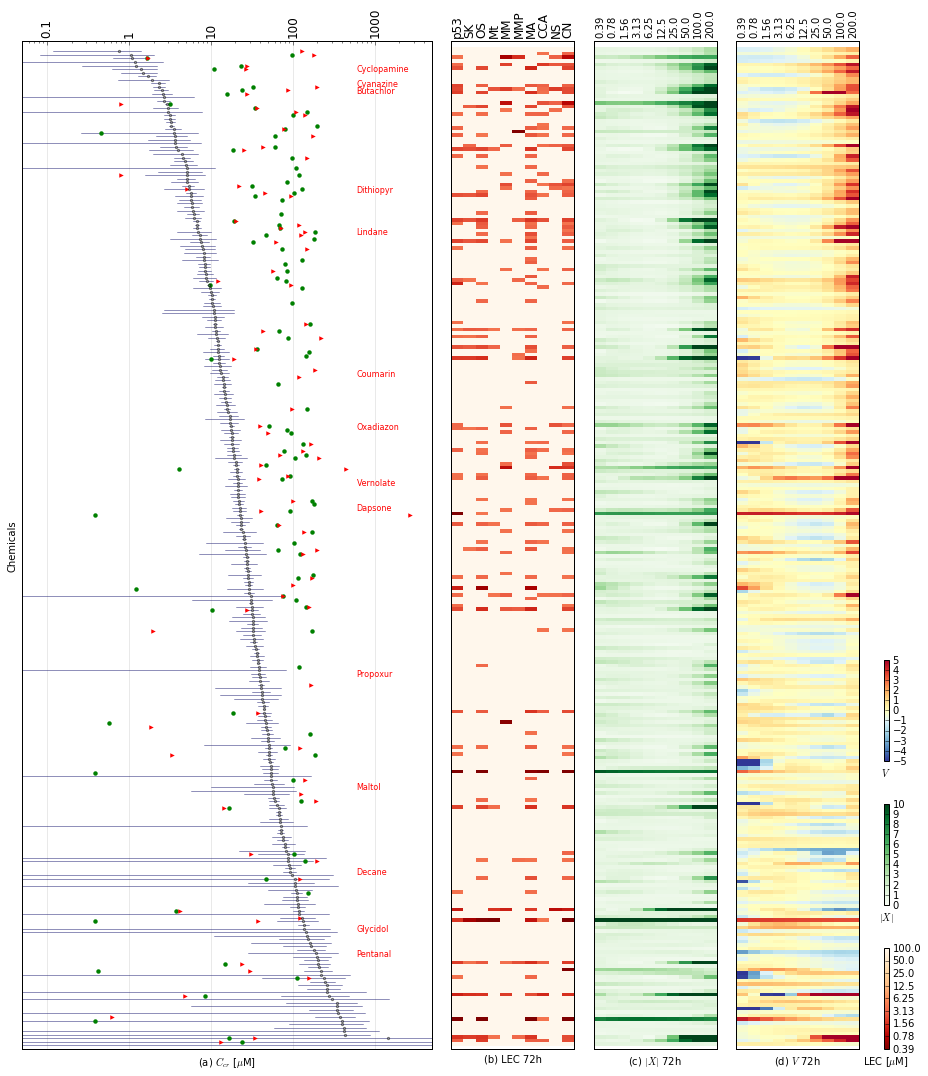

In [11]:
SID_paper = [
'TX001434', # captafol
'TX001420', # dicofol
'TX000759',  # butachlor
'TX003421',
'TX009308',
'TX002151',
'TX000719',
'TX000934',
'TX009773', # pioglit
'TX006207',# faarglit
'TX006205',# troglit
'TX001449',# thiram
'TX001417', # fludioxonil
'TX007182',
'TX000777',
'TX000787', #u'Tetramethrin'
'TX001606', #coumaphos
'TX001606',
'TX011638'
] + \
[u'TX000814',
 u'TX000759',
 u'TX001408',
 u'TX001547',
 u'TX002233',
 u'TX000934',
 u'TX004463',
 u'TX009316',
 u'TX000685',
 u'TX001548',
 u'TX003197',
 u'TX001712',
 u'TX008764',
 u'TX002295']

FT2 = np.array(['p53', 'SK', 'OS', 'Mt', 'MM', 'MMP', 'MA', 'CCA', 'NS', 'CN'])

# Subset the data
Rec_pct,X_min,X_pct=0.7,0.72,30
#X_min,X_pct=0.71,30

Cond0 = (CRIT_df['norecov']==1) & \
        (CRIT_df['rs_norecov']>=Rec_pct) & \
        (CRIT_df['min_pert']>=X_min)

CRIT_res=CRIT_df[Cond0]

# Source data 
X_lec = CRIT_res.copy()
X_lec['lec_min'][(X_lec['lec_min']==1e6)]=None
X_lec.sort(columns=['rs_norecov_mn'],ascending=[0],inplace=True)

# Perturbation and velocity
SID1 = [i[0] for i in X_lec.index]
V72_1_zs=V72_zs.ix[SID1,:]
X72_1_zs=X72_zs.ix[SID1,:]

Nrm = mpl.colors.Normalize(vmin=0,vmax=1.0)
myCol = cm.ScalarMappable(Nrm,cmap=cm.jet) 

fig=pl.figure(figsize=(15,20))
gs1 = gridspec.GridSpec(1,4,width_ratios=[1,0.3,0.3,0.3])
#ax = pl.subplot(1,2,1)
ax = pl.subplot(gs1[0,0])
#ax.set_title(r"$C_cr$ 72h")

#ax.scatter(X_lec.rs_norecov_mn,range(X_lec.shape[0]),s=20,c=X_lec.rs_norecov,zorder=3,alpha=0.5,vmin=0,vmax=1.0,cmap=cm.Blues)
ax.scatter(X_lec.rs_norecov_mn,range(X_lec.shape[0]),s=5,c='grey',marker='o',zorder=5,alpha=0.5)
X1_lec = X_lec.copy()
X1_lec['lec_min'][X1_lec['lec_min']>1e5]=None
Col1=np.array(X1_lec.shape[0]*['green'])
Col1[X1_lec.lec_min<X1_lec.rs_norecov_mn]='red'

ax.scatter(X1_lec.lec_min,range(X1_lec.shape[0]),s=20,marker='o',c='green',zorder=3,alpha=1,lw=0)
ax.scatter(X1_lec.CN50_um,range(X1_lec.shape[0]),s=20,marker='>',c='red',zorder=3,alpha=1,lw=0)

for i in range(X_lec.shape[0]):
    x = X_lec.irow(i)
    x0 =x['rs_norecov_mn'] 
    x1= x0-x['rs_norecov_sd']
    if x1<0: x1=0.01
    x2= x0+x['rs_norecov_sd']
    c1 = myCol.to_rgba(x['rs_norecov'])
    ax.add_line(mlines.Line2D((x1,x2),(i,i), lw=0.5,color="#222277",zorder=1))
    # Where's the LEC
    lec=x['lec_min']
    #if lec<1e6:
    #    c_ij = Circle([lec,i],radius=0.5,facecolor='#ff0000',alpha=1,fill=True,visible=True,zorder=10)
    #    ax.add_artist(c_ij)
    if x.name[0] in SID_paper:
        ax.text(6e2,i,x.name[1],ha='left',va='center',color='red',fontproperties=fm.FontProperties(size=8))

ax.set_xscale('log')
ax.set_ylim(-1,X_lec.shape[0]+2)
ax.set_xlim(0.05,5e3)
ax.set_xlabel(r"(a) $C_{cr}$ [$\mu$M]")
ax.set_ylabel(r"Chemicals")

Conc=10.0**np.array(range(-1,4))
ax.set_xticks(Conc, minor=False)
##xl=ax.set_xticklabels(['$0.1\muM$','$1\muM$','$10\muM$','$100\muM$','$1000\muM$'], minor=False,rotation=90)
xl=ax.set_xticklabels(['0.1','1','10','100','1000'], minor=False,rotation=90)
for conc in Conc:
    ax.add_line(mlines.Line2D((conc,conc),(-1,X1_lec.shape[0]+2), lw=0.5,color="#aaaaaa",alpha=0.5,zorder=0))
    
ax.xaxis.tick_top()
for tick in ax.get_xticklines(): 
    tick.set_visible(True)
for tick in ax.get_xticklabels(): 
    tick.set_fontsize(12)

for tick in ax.get_yticklines(): 
    tick.set_visible(False)
for tick in ax.get_yticklabels(): 
    tick.set_visible(False)


uM_log = VD1.conc.unique()
uM     =np.round(10**np.array(uM_log + 6,dtype=np.float),decimals=2)
uM_lab = [r"%5.2f$\muM$" % i for i in  uM]


# Plot the LECs for HCS endpoints at 72 h
ax = pl.subplot(gs1[0,1])

ax.xaxis.tick_top()
ax.set_ylim(-1,X_lec.shape[0]+2)
hm=ax.pcolor(X_lec[FT2],cmap=cm.OrRd_r,vmin=-6.4,vmax=0)
#ax.set_axis_off()
ax.set_xticks(np.arange(len(FT2))+0.5, minor=False)
xl=ax.set_xticklabels(FT2,rotation=90)
for tick in ax.get_xticklines(): 
    tick.set_visible(False)
for tick in ax.get_xticklabels(): 
    tick.set_fontsize(12)

for tick in ax.get_yticklines(): 
    tick.set_visible(False)
for tick in ax.get_yticklabels(): 
    tick.set_visible(False)
ax.set_xlabel(r"(b) LEC 72h")

ax1 = fig.add_axes([0.88,0.1,0.05,0.07])
ax1.set_axis_off()
cb = pl.colorbar(hm,ax=ax1)
cb.ax.set_xlabel(r'LEC [$\mu$M]')
cb.ax.set_yticks(np.arange(len(uM))-0.5, minor=False)
cb.ax.set_yticklabels(uM)
#cb.update_ticks()

ax = pl.subplot(gs1[0,2])
#ax.set_title(r"FC & LEC 72h")

ax.xaxis.tick_top()
ax.set_ylim(-1,X_lec.shape[0]+2)
ax.set_xlim(right=10)
#ax.pcolor(X_fc[FT+['norm']],cmap=cm.RdYlBu_r,edgecolors='white',lw=0.5,vmin=-4,vmax=4)
hm=ax.pcolor(X72_1_zs,cmap=cm.Greens,vmin=0,vmax=10)
#ax.set_axis_off()

ax.set_xticks(np.arange(len(uM))+0.5, minor=False)
xl=ax.set_xticklabels(uM,rotation=90)
for tick in ax.get_xticklines(): 
    tick.set_visible(False)
for tick in ax.get_xticklabels(): 
    tick.set_fontsize(10)

for tick in ax.get_yticklines(): 
    tick.set_visible(False)
for tick in ax.get_yticklabels(): 
    tick.set_visible(False)
ax.set_xlabel(r"(c) $|X|$ 72h")

ax1 = fig.add_axes([0.88,0.2,0.05,0.07])
ax1.set_axis_off()
cb = pl.colorbar(hm,ax=ax1)
cb.ax.set_xlabel(r'$|X|$')


ax = pl.subplot(gs1[0,3])

ax.xaxis.tick_top()
ax.set_ylim(-1,X_lec.shape[0]+2)
ax.set_xlim(right=10)
hm=ax.pcolor(V72_1_zs,cmap=cm.RdYlBu_r,vmin=-5,vmax=5)
        
ax.set_xticks(np.arange(len(uM))+0.5, minor=False)
xl=ax.set_xticklabels(uM,rotation=90)
for tick in ax.get_xticklines(): 
    tick.set_visible(False)
for tick in ax.get_xticklabels(): 
    tick.set_fontsize(10)

for tick in ax.get_yticklines(): 
    tick.set_visible(False)
for tick in ax.get_yticklabels(): 
    tick.set_visible(False)
ax.set_xlabel(r"(d) $V$ 72h")

ax1 = fig.add_axes([0.88,0.3,0.05,0.07])
ax1.set_axis_off()
cb = pl.colorbar(hm,ax=ax1)
cb.ax.set_xlabel(r'$V$')

pl.subplots_adjust(wspace=0.1,hspace=0.3,top=0.8,bottom=0.1)

